In [12]:
#Imports
import pandas as pd
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
import numpy as np
from keras.src.layers import Dropout
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from keras.optimizers import SGD
from sklearn.metrics import precision_recall_curve, auc
import seaborn as sns
from keras import metrics

In [13]:
#Data importing
dataFrame = pd.read_csv('./dataset.csv')

# variable I will try to predict: popularity
# the dataset is taken from: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/

dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

                     duration_ms  explicit  danceability    energy       key  \
duration_ms             1.000000 -0.065263     -0.073426  0.058523  0.008114   
explicit               -0.065263  1.000000      0.122507  0.096955  0.004484   
danceability           -0.073426  0.122507      1.000000  0.134325  0.036469   
energy                  0.058523  0.096955      0.134325  1.000000  0.048006   
key                     0.008114  0.004484      0.036469  0.048006  1.000000   
loudness               -0.003470  0.108588      0.259077  0.761690  0.038590   
mode                   -0.035556 -0.037212     -0.069219 -0.078362 -0.135916   
speechiness            -0.062600  0.307952      0.108626  0.142509  0.020418   
acousticness           -0.103788 -0.094403     -0.171533 -0.733906 -0.040937   
instrumentalness        0.124371 -0.103404     -0.185606 -0.181879 -0.006823   
liveness                0.010321  0.032549     -0.131617  0.184796 -0.001600   
valence                -0.154479 -0.0033

<Axes: >

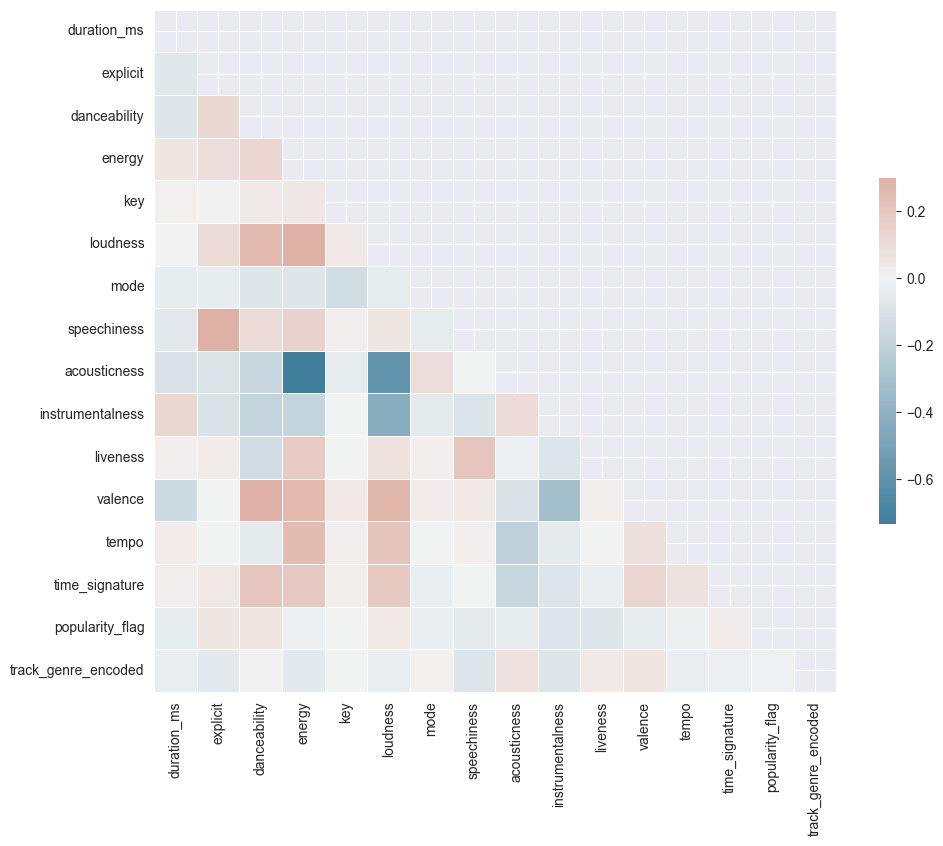

In [14]:
# Calculate correlation matrix
corr_matrix = dataFrame.corr()

# Show correlation matrix
print(corr_matrix)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True,)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Label to integer mapping: {'acoustic': 0, 'afrobeat': 1, 'alt-rock': 2, 'alternative': 3, 'ambient': 4, 'anime': 5, 'black-metal': 6, 'bluegrass': 7, 'blues': 8, 'brazil': 9, 'breakbeat': 10, 'british': 11, 'cantopop': 12, 'chicago-house': 13, 'children': 14, 'chill': 15, 'classical': 16, 'club': 17, 'comedy': 18, 'country': 19, 'dance': 20, 'dancehall': 21, 'death-metal': 22, 'deep-house': 23, 'detroit-techno': 24, 'disco': 25, 'disney': 26, 'drum-and-bass': 27, 'dub': 28, 'dubstep': 29, 'edm': 30, 'electro': 31, 'electronic': 32, 'emo': 33, 'folk': 34, 'forro': 35, 'french': 36, 'funk': 37, 'garage': 38, 'german': 39, 'gospel': 40, 'goth': 41, 'grindcore': 42, 'groove': 43, 'grunge': 44, 'guitar': 45, 'happy': 46, 'hard-rock': 47, 'hardcore': 48, 'hardstyle': 49, 'heavy-metal': 50, 'hip-hop': 51, 'honky-tonk': 52, 'house': 53, 'idm': 54, 'indian': 55, 'indie': 56, 'indie-pop': 57, 'industrial': 58, 'iranian': 59, 'j-dance': 60, 'j-idol': 61, 'j-pop': 62, 'j-rock': 63, 'jazz': 64, 'k-pop': 65, 'kids': 66, 'latin': 67, 'latino': 68, 'malay': 69, 'mandopop': 70, 'metal': 71, 'metalcore': 72, 'minimal-techno': 73, 'mpb': 74, 'new-age': 75, 'opera': 76, 'pagode': 77, 'party': 78, 'piano': 79, 'pop': 80, 'pop-film': 81, 'power-pop': 82, 'progressive-house': 83, 'psych-rock': 84, 'punk': 85, 'punk-rock': 86, 'r-n-b': 87, 'reggae': 88, 'reggaeton': 89, 'rock': 90, 'rock-n-roll': 91, 'rockabilly': 92, 'romance': 93, 'sad': 94, 'salsa': 95, 'samba': 96, 'sertanejo': 97, 'show-tunes': 98, 'singer-songwriter': 99, 'ska': 100, 'sleep': 101, 'songwriter': 102, 'soul': 103, 'spanish': 104, 'study': 105, 'swedish': 106, 'synth-pop': 107, 'tango': 108, 'techno': 109, 'trance': 110, 'trip-hop': 111, 'turkish': 112, 'world-music': 113}

This is a lot to go through but basically it is assigning each genre a number so that I now have a quantitative variable instead of a qualitative one. this allows for a neural net to run on the data.

In [15]:
inputs = ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
target = ['popularity_flag']

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2, random_state=42)

In [17]:
# Assuming y_train is your training labels
positive_class_proportion = np.mean(ytrain)

print(f"The AUPRC baseline is: {positive_class_proportion}")

The AUPRC baseline is: 0.24455043859649123


This means that if my model is guessing it should have a score of 0.24 or 24% as the I am working with an unbalanced dataset. It focuses on the trade-off between precision and recall, and the AUPRC (Area Under the Precision-Recall Curve) is  useful for evaluating imbalanced dataset models... like what I have. It provides a measure of how well the model can increase its prediction accuracy on the positive class without incurring too many false positive errors.

In [18]:
model = neighbors.KNeighborsRegressor(2)
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)
ypred = (ypred > 0.5).astype(int)  # Apply a threshold 

y_train_scores = model.predict(xtrain)
y_test_scores = model.predict(xtest)

#Apply same threshold to train predictions
y_train_pred = (y_train_scores > 0.5).astype(int)
y_test_pred = (y_test_scores > 0.5).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")

AUPRC on Training set: 0.8026849338340913
AUPRC on Testing set: 0.48990156981784766
F1 Score on Training set: 0.6470374188853175
F1 Score on Testing set: 0.32590855803048063


this does fine on the training set but leaves much to be desired on the testing set. for this project any f1 score over .5 will be a good model

In [19]:
model = neighbors.KNeighborsClassifier(n_neighbors=2)
model.fit(xtrain, ytrain.values.ravel())
y_train_scores = model.predict_proba(xtrain)[:, 1]
y_test_scores = model.predict_proba(xtest)[:, 1]

#Apply same threshold to train predictions
y_train_pred = (y_train_scores > 0.5).astype(int)
y_test_pred = (y_test_scores > 0.5).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")

AUPRC on Training set: 0.8026849338340913
AUPRC on Testing set: 0.48990156981784766
F1 Score on Training set: 0.6470374188853175
F1 Score on Testing set: 0.32590855803048063


In [20]:
# Data importing
dataFrame = pd.read_csv('./dataset.csv')
dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

# Split into features and target
X = dataFrame.drop(columns=['popularity_flag'])
y = dataFrame['popularity_flag']

# Convert to tensor
X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y.values, dtype=tf.float32)

# Calculate the index at which to split the dataset
train_size = int(0.8 * len(X))

# Manually slice the tensors for train/test sets
x_train_tensor = X_tensor[:train_size]
y_train_tensor = y_tensor[:train_size]
x_test_tensor = X_tensor[train_size:]
y_test_tensor = y_tensor[train_size:]


In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14205413853077162885
xla_global_id: -1
]


In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
@keras.saving.register_keras_serializable()
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@keras.saving.register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_true,y_pred))

@keras.saving.register_keras_serializable()
def r_squared(y_true, y_pred,):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

@keras.saving.register_keras_serializable()
def r_squared_loss(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return 1 - r2  # or you can return -r2 to minimize the negative value

def custom_loss(y_true, y_pred):
    # Assign costs
    cost_fp = 2.0  # cost of a false positive
    cost_fn = 5.0  # cost of a false negative

    # Calculate binary cross-entropy
    bce = tf.keras.losses.BinaryCrossentropy()
    base_loss = bce(y_true, y_pred)

    # Calculate false positives and false negatives
    y_pred_binary = tf.round(y_pred)
    fp = tf.math.reduce_sum(tf.math.multiply(tf.math.subtract(y_pred_binary, y_true), cost_fp))
    fn = tf.math.reduce_sum(tf.math.multiply(tf.math.subtract(y_true, y_pred_binary), cost_fn))

    # Add to base loss
    return base_loss + fp + fn

def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss'])+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

In [21]:
input_shape = (x_train_tensor.shape[1],)

# Build model function
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [22]:

# Define a set of class weights to evaluate
class_weights_grid = [{0:1.0, 1:weight} for weight in np.linspace(1, 5, 100)]  # Drop the 100 down to 10 if you are running this on a weaker computer.

# Initial placeholders for the best weights and highest f1 score
best_class_weights = None
highest_f1 = 0

for class_weights in class_weights_grid:

    #Build and compile model as before
    model = build_model(input_shape)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.Precision(name='precision'),
                           metrics.Recall(name='recall'),
                           metrics.AUC(name='auc')])

    # Train model with current class weight
    model.fit(x_train_tensor,
              y_train_tensor,
              epochs=20,
              validation_split=0.1,
              batch_size=200,
              class_weight=class_weights,
              verbose=0) # Turn off output 

    # Evaluate F1 Score
    y_train_scores = model.predict(x_train_tensor).flatten()
    y_train_pred = (y_train_scores > 0.5).astype(int)
    f1 = f1_score(y_train_tensor, y_train_pred)

    if f1 > highest_f1:
        best_class_weights = class_weights
        highest_f1 = f1

# Output the best class weights
print("Best class weights: ", best_class_weights)
print("Best F1 score: ", highest_f1)

2850/2850 [==============================] - 1s 184us/step
Best class weights:  {0: 1.0, 1: 3.6666666666666665}
Best F1 score:  0.4032882180939541


Now that I have found the best class weight I will use that to train the final model

In [20]:

# Class weights for cost-sensitive training
class_weights = {0: 1., 1: 3.9}  # You can fine-tune this based on your specific case
early_stopping = EarlyStopping(monitor='accuracy', patience=50, restore_best_weights=True)

with tf.device('/GPU:0'):
    # Regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(name='accuracy'), 
                           metrics.Precision(name='precision'), 
                           metrics.Recall(name='recall'), 
                           metrics.AUC(name='auc')])
    
    model.fit(x_train_tensor, y_train_tensor, epochs=20,validation_split=0.1, batch_size=200, class_weight = class_weights)

    # Get model's predictions (as class labels using threshold of 0.5)
    y_train_scores = model.predict(x_train_tensor).flatten()
    y_test_scores = model.predict(x_test_tensor).flatten()
    y_train_pred = (y_train_scores > 0.5).astype(int)
    y_test_pred = (y_test_scores > 0.5).astype(int)

    print(f"Summarizing model performance:\n")

    # Precision-Recall curve
    precision_train, recall_train, _ = precision_recall_curve(y_train_tensor, y_train_pred)
    precision_test, recall_test, _ = precision_recall_curve(y_test_tensor, y_test_pred)

    # Calculate AUC
    auprc_train = auc(recall_train, precision_train)
    auprc_test = auc(recall_test, precision_test)
    print(f"AUPRC on Training set: {auprc_train}")
    print(f"AUPRC on Testing set: {auprc_test}")

    # Calculate F1 Score
    f1_train = f1_score(y_train_tensor, y_train_pred)
    f1_test = f1_score(y_test_tensor, y_test_pred)
    print(f"F1 Score on Training set: {f1_train}")
    print(f"F1 Score on Testing set: {f1_test}")

Epoch 1/20
411/411 [==============================] - 0s 657us/step - loss: 3294.8499 - accuracy: 0.4084 - precision: 0.2523 - recall: 0.6867 - auc: 0.5008 - val_loss: 0.7671 - val_accuracy: 0.2580 - val_precision: 0.2580 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
411/411 [==============================] - 0s 436us/step - loss: 1.1837 - accuracy: 0.2520 - precision: 0.2520 - recall: 1.0000 - auc: 0.5007 - val_loss: 0.7862 - val_accuracy: 0.2580 - val_precision: 0.2580 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
411/411 [==============================] - 0s 456us/step - loss: 1.1837 - accuracy: 0.2520 - precision: 0.2520 - recall: 1.0000 - auc: 0.5038 - val_loss: 0.7633 - val_accuracy: 0.2580 - val_precision: 0.2580 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/20
411/411 [==============================] - 0s 434us/step - loss: 1.1837 - accuracy: 0.2520 - precision: 0.2520 - recall: 1.0000 - auc: 0.4986 - val_loss: 0.7662 - val_accuracy: 0.2580 - val_precision: 0.2580 - va

In [12]:
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(x_train_tensor, y_train_tensor, epochs=20,validation_split=0.1, batch_size=200)#Data importing
dataFrame = pd.read_csv('./dataset.csv')

# variable I will try to predict: popularity
# the dataset is taken from: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/

dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

inputs = ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
target = ['popularity_flag']

X_train, X_test, y_train, y_test = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Print the confusion matrix using Matplotlib
y_train_scores_dt = dt.predict_proba(X_train)[:, 1]
y_test_scores_dt = dt.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")

AUPRC on Training set: 0.9995438542449004
AUPRC on Testing set: 0.5892483905553867


In [13]:

#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train, y_train.values.ravel())
y_train_predrf = rf.predict(X_train)
y_test_predrf = rf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_true=y_test, y_pred=y_test_predrf)


y_train_scores_dt = rf.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")


AUPRC on Training set: 0.9986238265622851
AUPRC on Testing set: 0.7408075838365074


In [ ]:
def custom_auc(y_true, y_pred):
    # check if y_pred is 1-dimensional
    if len(y_pred.shape) == 1:
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
    else:
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    return auc(recall, precision)

# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [20,  80, 100],
    'max_features': ['sqrt'],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf_0 = RandomForestClassifier(n_jobs=-1, random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_0, param_grid=param_grid, scoring=make_scorer(custom_auc, needs_proba=True))
grid_search.fit(X_train, y_train.values.ravel())
print ('Best Parameters: ', grid_search.best_params_, ' \n')

#Create a Gaussian Classifier
rf2=RandomForestClassifier(n_estimators=1000, max_depth = 100, max_features = 'sqrt', min_samples_leaf =1,min_samples_split =2, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf2.fit(X_train, y_train.values.ravel())

y_train_scores_dt = rf2.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf2.predict_proba(X_test)[:, 1]

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")